In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch.distributions import Categorical, Exponential

In [3]:
from utils_ import hawkes, intensity_hawkes, generate_hawkes, generate_autoregressive_data

# Visualize Timeseries

In [4]:
def visualize_points_series(timeseries, num_series=50):
    """
    Input:
        timeseries: Tensor of shape T x N
    """
    history = np.array(timeseries)
    T, N = history.shape
    print(T,N)
    num_series = min(num_series, N)
    series_idxs = np.random.randint(low=0, high=N, size=num_series)
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(series_idxs):
        plt.scatter(history[:,idx], i+np.zeros(T))

100 160


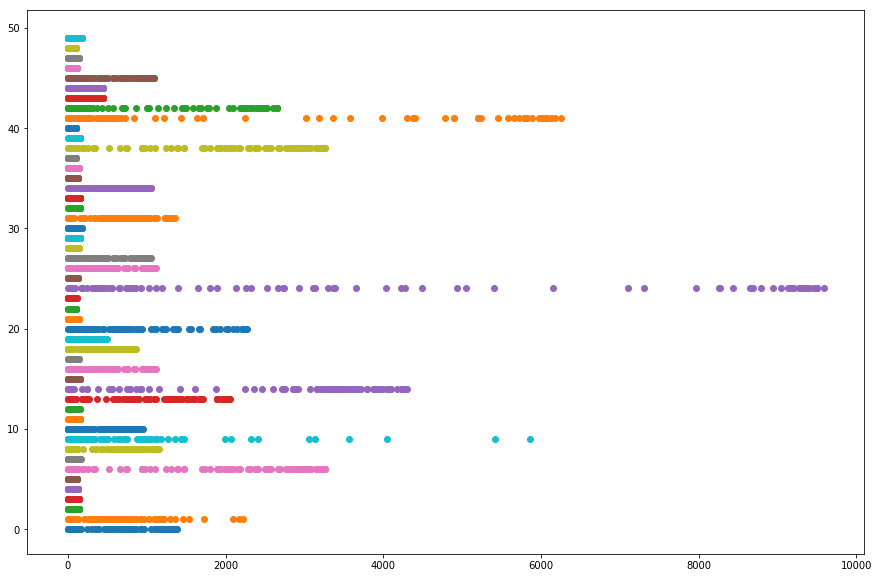

In [8]:
# Returns both the series and the intervals
# Shape: T x N x 2
timeseries = generate_autoregressive_data(time_step=100, num_sample=80, num_clusters=2)
# timeseries = generate_hawkes(time_step=100, num_sample=80, num_clusters=2)
# Extract only the series
timeseries = timeseries[:,:,0]
visualize_points_series(timeseries)

# Visualize Intervals

In [18]:
def visualize_intervals(intervals, num_series=5):
    """
    Input:
        timeseries: Tensor of shape T x N
    """
    intervals = np.array(intervals)
    T, N = intervals.shape
    print(T,N)
    num_series = min(num_series, N)
    series_idxs = np.random.randint(low=0, high=N, size=num_series)
    plt.figure(figsize=(15,10))
    max_interval = intervals[:,series_idxs].max()
    
    for i, idx in enumerate(series_idxs):
        plt.subplot(num_series,1,i+1)
        plt.plot(intervals[:,idx])
        plt.ylim(0,max_interval)

100 240


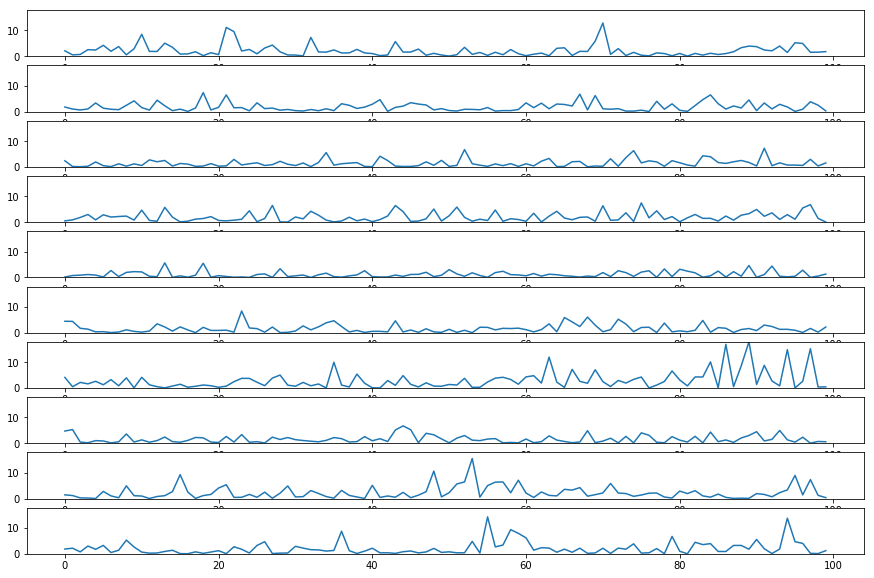

In [22]:
# Returns both the series and the intervals
# Shape: T x N x 2
_timeseries = generate_autoregressive_data(time_step=100, num_sample=80, num_clusters=3)
# _timeseries = generate_hawkes(time_step=100, num_sample=80, num_clusters=3)
# Extract only the intervals
intervals = _timeseries[:,:,1]
visualize_intervals(intervals, num_series=10)